In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

import struct

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelBinarizer

# Get the data

In [2]:
def load_csv(path):
    return pd.read_csv(path)

In [3]:
training_raw = load_csv("data/train_V2_copia.csv")

In [4]:
training_raw.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,b5c039907be0cd,c0c67de704074b,0,1,69.38,0,0,5,60,...,0,4002.0,0,0.0,0,0,960.400,5,0,0.5111
1,00003cf31d0d9e,9c5dfe6934503f,e0f5b680be65a3,0,0,0.00,0,0,0,74,...,0,0.0,0,0.0,0,0,9.335,0,1568,0.0000
2,0000d08a0af004,0a367e93925db9,60df85422b2a0b,0,0,0.00,0,0,0,67,...,0,0.0,0,0.0,0,0,75.780,1,0,0.3214
3,0000f8e9e04779,fb474827a8fad0,c012522f04e75b,1,3,110.30,0,0,3,46,...,0,3381.0,0,417.4,0,0,2915.000,4,1491,0.8925
4,000145fb127119,3af85c797b4002,62debdaa591363,0,0,135.40,0,0,0,69,...,1,0.0,0,0.0,0,0,134.200,3,0,0.3617


In [5]:
training_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220216 entries, 0 to 220215
Data columns (total 29 columns):
Id                 220216 non-null object
groupId            220216 non-null object
matchId            220216 non-null object
assists            220216 non-null int64
boosts             220216 non-null int64
damageDealt        220216 non-null float64
DBNOs              220216 non-null int64
headshotKills      220216 non-null int64
heals              220216 non-null int64
killPlace          220216 non-null int64
killPoints         220216 non-null int64
kills              220216 non-null int64
killStreaks        220216 non-null int64
longestKill        220216 non-null float64
matchDuration      220216 non-null int64
matchType          220216 non-null object
maxPlace           220216 non-null int64
numGroups          220216 non-null int64
rankPoints         220216 non-null int64
revives            220216 non-null int64
rideDistance       220216 non-null float64
roadKills         

We have to format the three first attributes because of theses strings can't be used to fit the model.

In [6]:
training_format = training_raw.copy()

In [7]:
training_format["Id"] = np.arange(len(training_format))
training_format["groupId"] = np.arange(len(training_format))
training_format["matchId"] = np.arange(len(training_format))

In [8]:
#Id
training_raw = training_raw.sort_values(by=['Id'])
counter = 0
flag = False
for x in range(len(training_raw)-1):
    if training_raw['Id'].iloc[x] != training_raw['Id'].iloc[x+1]:
        counter += 1
        flag = True
    else: flag = False
    training_raw.at[x,'Id']=counter
    
last = len(training_raw)-1
    
if flag:
    counter += 1
training_raw.at[last,'Id']=counter

In [9]:
training_raw

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,1,b5c039907be0cd,c0c67de704074b,0,1,69.380,0,0,5,60,...,0,4002.0,0,0.0,0,0,960.400,5,0,0.5111
1,2,9c5dfe6934503f,e0f5b680be65a3,0,0,0.000,0,0,0,74,...,0,0.0,0,0.0,0,0,9.335,0,1568,0.0000
2,3,0a367e93925db9,60df85422b2a0b,0,0,0.000,0,0,0,67,...,0,0.0,0,0.0,0,0,75.780,1,0,0.3214
3,4,fb474827a8fad0,c012522f04e75b,1,3,110.300,0,0,3,46,...,0,3381.0,0,417.4,0,0,2915.000,4,1491,0.8925
4,5,3af85c797b4002,62debdaa591363,0,0,135.400,0,0,0,69,...,1,0.0,0,0.0,0,0,134.200,3,0,0.3617
5,6,469383b1cea848,fc4342b507c563,0,1,23.450,0,0,3,59,...,0,3075.0,0,0.0,0,0,2270.000,3,0,0.5000
6,7,40546f1d8d7817,52cf847f91fc40,0,0,54.390,0,0,2,74,...,0,0.0,0,0.0,0,0,652.800,4,0,0.1379
7,8,b4ef3a3a85d3b2,1fe9c3c34265c6,1,3,21.750,0,0,10,41,...,1,0.0,0,0.0,1,0,3030.000,3,0,0.9643
8,9,30a44124ed8d1c,3462330f7fd5ec,0,0,137.300,1,0,0,28,...,0,0.0,0,0.0,0,0,127.800,1,1463,0.3077
9,10,f687d12a73cd15,5cde963c96eaaa,0,0,61.050,1,0,1,80,...,0,0.0,0,0.0,0,0,119.300,1,1434,0.1923


In [26]:
training_raw

,Unnamed: 0,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,1,2,0,e0f5b680be65a3,0,0,0.000,0,0,0,...,0,0.0,0,0.0,0,0,9.335,0,1568,0.0000
1,0,1,1,c0c67de704074b,0,1,69.380,0,0,5,...,0,4002.0,0,0.0,0,0,960.400,5,0,0.5111
2,2,3,2,60df85422b2a0b,0,0,0.000,0,0,0,...,0,0.0,0,0.0,0,0,75.780,1,0,0.3214
3,3,4,3,c012522f04e75b,1,3,110.300,0,0,3,...,0,3381.0,0,417.4,0,0,2915.000,4,1491,0.8925
4,4,5,4,62debdaa591363,0,0,135.400,0,0,0,...,1,0.0,0,0.0,0,0,134.200,3,0,0.3617
5,5,6,5,fc4342b507c563,0,1,23.450,0,0,3,...,0,3075.0,0,0.0,0,0,2270.000,3,0,0.5000
6,6,7,6,52cf847f91fc40,0,0,54.390,0,0,2,...,0,0.0,0,0.0,0,0,652.800,4,0,0.1379
7,7,8,7,1fe9c3c34265c6,1,3,21.750,0,0,10,...,1,0.0,0,0.0,1,0,3030.000,3,0,0.9643
8,8,9,8,3462330f7fd5ec,0,0,137.300,1,0,0,...,0,0.0,0,0.0,0,0,127.800,1,1463,0.3077
9,9,10,9,5cde963c96eaaa,0,0,61.050,1,0,1,...,0,0.0,0,0.0,0,0,119.300,1,1434,0.1923


In [11]:
training_raw.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,...,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000,220216.000000
mean,0.232858,1.113153,130.920473,0.657159,0.226151,1.368788,47.607417,506.440495,0.926595,0.544570,...,0.163290,602.564687,0.003701,4.558532,0.023486,0.007520,1156.380998,3.672903,608.501857,0.472838
std,0.589536,1.723522,171.673314,1.148812,0.600173,2.665566,27.472573,627.540576,1.563712,0.712567,...,0.466527,1484.673601,0.080414,30.883989,0.165181,0.090046,1184.322981,2.468826,740.098821,0.307505
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,155.475000,2.000000,0.000000,0.200000
50%,0.000000,0.000000,84.170000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,690.500000,3.000000,0.000000,0.458300
75%,0.000000,2.000000,186.000000,1.000000,0.000000,2.000000,71.000000,1172.000000,1.000000,1.000000,...,0.000000,0.032875,0.000000,0.000000,0.000000,0.000000,1978.000000,5.000000,1495.000000,0.740700
max,21.000000,21.000000,5479.000000,32.000000,40.000000,52.000000,100.000000,2152.000000,48.000000,14.000000,...,16.000000,28450.000000,8.000000,2295.000000,5.000000,4.000000,13530.000000,72.000000,1972.000000,1.000000


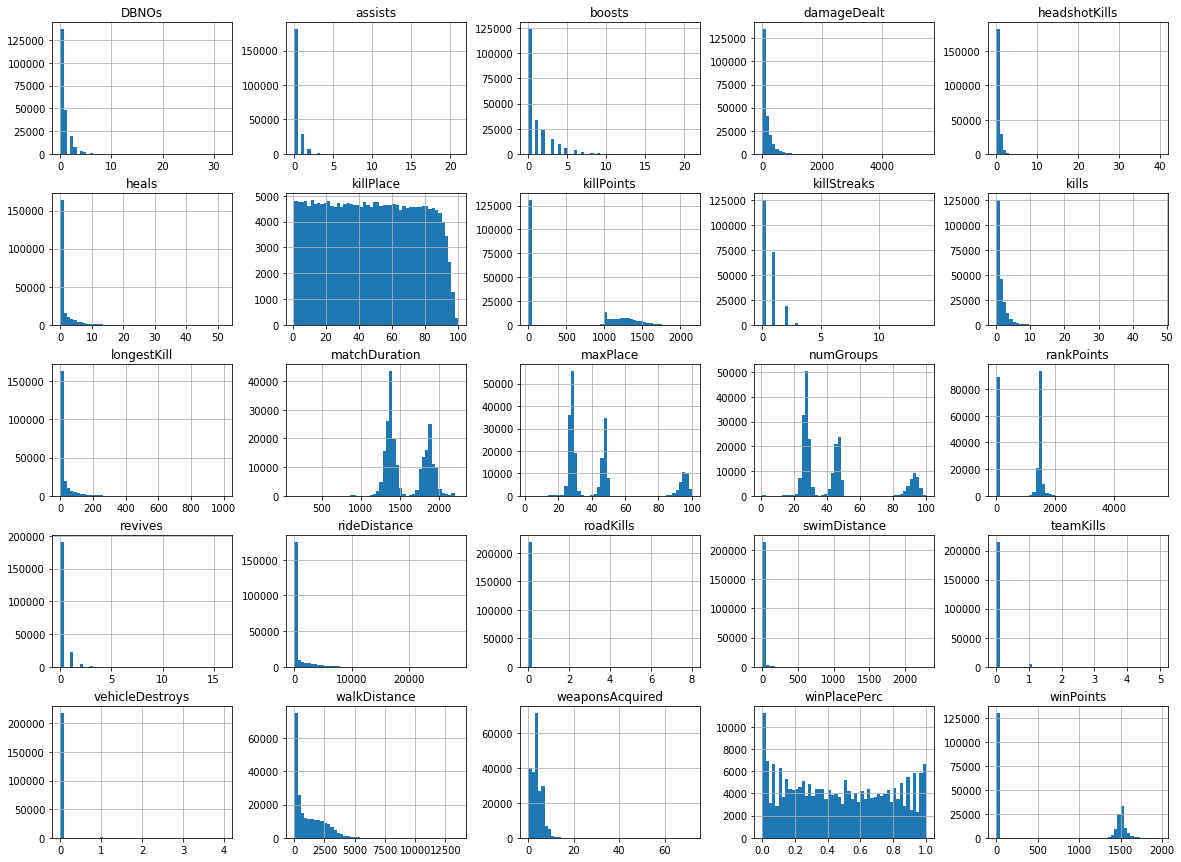

In [12]:
%matplotlib inline
training_raw.hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
#training_format["killPlaceAVG"] = training_format["killPlace"].mean()
#training_format["overallKills"] = 
#training_format["overallDBNOS"] = 
#training_format["overallMatches"] = 

### Create test set

In [14]:
training_X, test_X, training_labels, test_labels = train_test_split(training_format.drop("winPlacePerc", axis=1), training_format["winPlacePerc"], random_state=42)

In [15]:
print(f'Training data: {training_X.shape}\nTest data: {test_X.shape}')

Training data: (165162, 28)
Test data: (55054, 28)


# Discover and visualize the data to gain insights

### Looking for Correlations

In [16]:
training_copy = training_raw.copy()

In [17]:
corr_matrix = training_copy.corr()

In [18]:
corr_matrix["winPlacePerc"].sort_values(ascending=False)

winPlacePerc       1.000000
walkDistance       0.810800
boosts             0.634589
weaponsAcquired    0.583716
damageDealt        0.440679
heals              0.429340
kills              0.419347
longestKill        0.409979
killStreaks        0.376420
rideDistance       0.342884
assists            0.297902
DBNOs              0.278824
headshotKills      0.277534
revives            0.238868
swimDistance       0.148061
vehicleDestroys    0.071652
numGroups          0.043644
maxPlace           0.041392
roadKills          0.032796
killPoints         0.015227
teamKills          0.013951
rankPoints         0.011026
winPoints          0.009790
matchDuration     -0.003608
killPlace         -0.719037
Name: winPlacePerc, dtype: float64

##### Attributes that seem more correlated with "winPlacePerc" are:
walkDistance   
killPlace
boosts             
weaponsAcquired    
damageDealt        
heals              
kills 
longestKill       
killStreaks       
rideDistance     
assists           
DBNOs           
headshotKills   
revives

In [19]:
#attributes = ["winPlacePerc", "walkDistance", "killPlace",
#"boosts"]

#scatter_matrix(training_copy[attributes], figsize=(12, 8))

In [20]:
#training_copy.plot(kind="scatter", x="walkDistance", y="winPlacePerc",alpha=0.1)

In [21]:
#training_copy.plot(kind="scatter", x="matchDuration", y="winPlacePerc",alpha=0.1)

# Prepare the data for Machine Learning algorithms

### Handling Text and Categorical Attributes

In [22]:
encoder = LabelBinarizer()
training_format_cat = training_format["matchType"]
training_format_cat_1hot = encoder.fit_transform(training_format_cat)
training_format_cat_1hot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

# Select a model and train it

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(training_X, training_labels)

ValueError: could not convert string to float: '25850fce083be1'

In [ ]:
PUBG_predictions = lin_reg.predict(test_X)
lin_mse = mean_squared_error(test_labels, PUBG_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
lin_scores = cross_val_score(lin_reg, test_X, test_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(training_X, training_labels)

In [ ]:
PUBG_predictions = tree_reg.predict(test_X)
tree_mse = mean_squared_error(test_labels, PUBG_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
tree_scores = cross_val_score(tree_reg, test_X, test_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(training_X, training_labels)

In [ ]:
PUBG_predictions = forest_reg.predict(test_X)
forest_mse = mean_squared_error(test_labels, PUBG_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
forest_scores = cross_val_score(forest_reg, test_X, test_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
reg = linear_model.HuberRegressor()

In [ ]:
reg.fit(training_X, training_labels)

In [ ]:
PUBG_predictions = reg.predict(test_X)
mse = mean_squared_error(test_labels, PUBG_predictions)
rmse = np.sqrt(mse)
rmse

In [ ]:
scores = cross_val_score(reg, test_X, test_labels,
scoring="neg_mean_squared_error", cv=10)
scores = np.sqrt(-scores)
display_scores(scores)

# Fine-tune your model

# Present your solution

# Launch, monitor, and maintain your system